Import stuff

In [1]:
import numpy as np
import pandas as pd
import pickle
import subprocess
import pdb

%matplotlib notebook
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import keras
from keras.models import load_model

#allow one cell to display multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

Using TensorFlow backend.


Define a function to get the model output via built in keras functions. This is the "true" output that we want to make sure our cpp implementation matches. Simply load the scaling parameters and threshold, and use the predict function to get probabilities.

In [2]:
def test_keras(X,y):
    #load the model
    model = load_model('model.h5')

    #load the feature scaler
    scaler = pickle.load(open('standard_scaler.pickle', 'rb'))

    #load the prob threshold for classification
    thresh = pickle.load(open('thresh.pickle', 'rb'))

    #scale the features and reformat the labels
    X = scaler.transform(X)
    y = np.array([[val] for val in y['label']])

    #get the model output
    prob = model.predict(X)
    prob = prob.flatten()
    y_pred = (prob > thresh).astype(int)

    return prob, y_pred


Define a function to get the model output via the cpp executable. This is calling the cpp executable via command line, waiting for the program to complete and return its output, and then parsing the string result back into a floating point. The process is repeated for every example (row) in X. The cpp function returns "probability, predicted_class".

In [3]:
def test_cpp(X,y):
    #this is the path to the cpp executable. it's always relative to the main folder so no need to ever change this
    exe_path = 'xcode/Build/Products/Debug/neural_network_cpp'
    
    #get the X values as an numpy matrix rather than a pandas dataframe
    X = X.values
    
    #store the probability and predictions in arrays
    prob = []
    y_pred = []
    for row in X:                
        #package the input features as a string and get the output via command line
        feats = str(list(row))[1:-1].replace(',', '')
        process = subprocess.Popen(exe_path + ' ' + feats, stdout=subprocess.PIPE, stderr=subprocess.PIPE, stdin=subprocess.PIPE, shell=True)
        result, err = process.communicate()
                        
        #parse the output (format is "probability, class")
        result = result.decode('utf-8')[0:-1].split(',')
        prob_temp = float(result[0])
        y_pred_temp = int(result[1])

        prob.append(prob_temp)
        y_pred.append(y_pred_temp)

    return prob, y_pred


Evaluate the model using both the keras and cpp implementations. Compare the probabilities and classification results...they should be the same!

NOTE: make sure to re-build the cpp executable before running this next cell. Even if you made no changes to the cpp code, if you re-trained the model and then re-exported a header file, the cpp executable will be referencing the old header file.

<IPython.core.display.Javascript object>


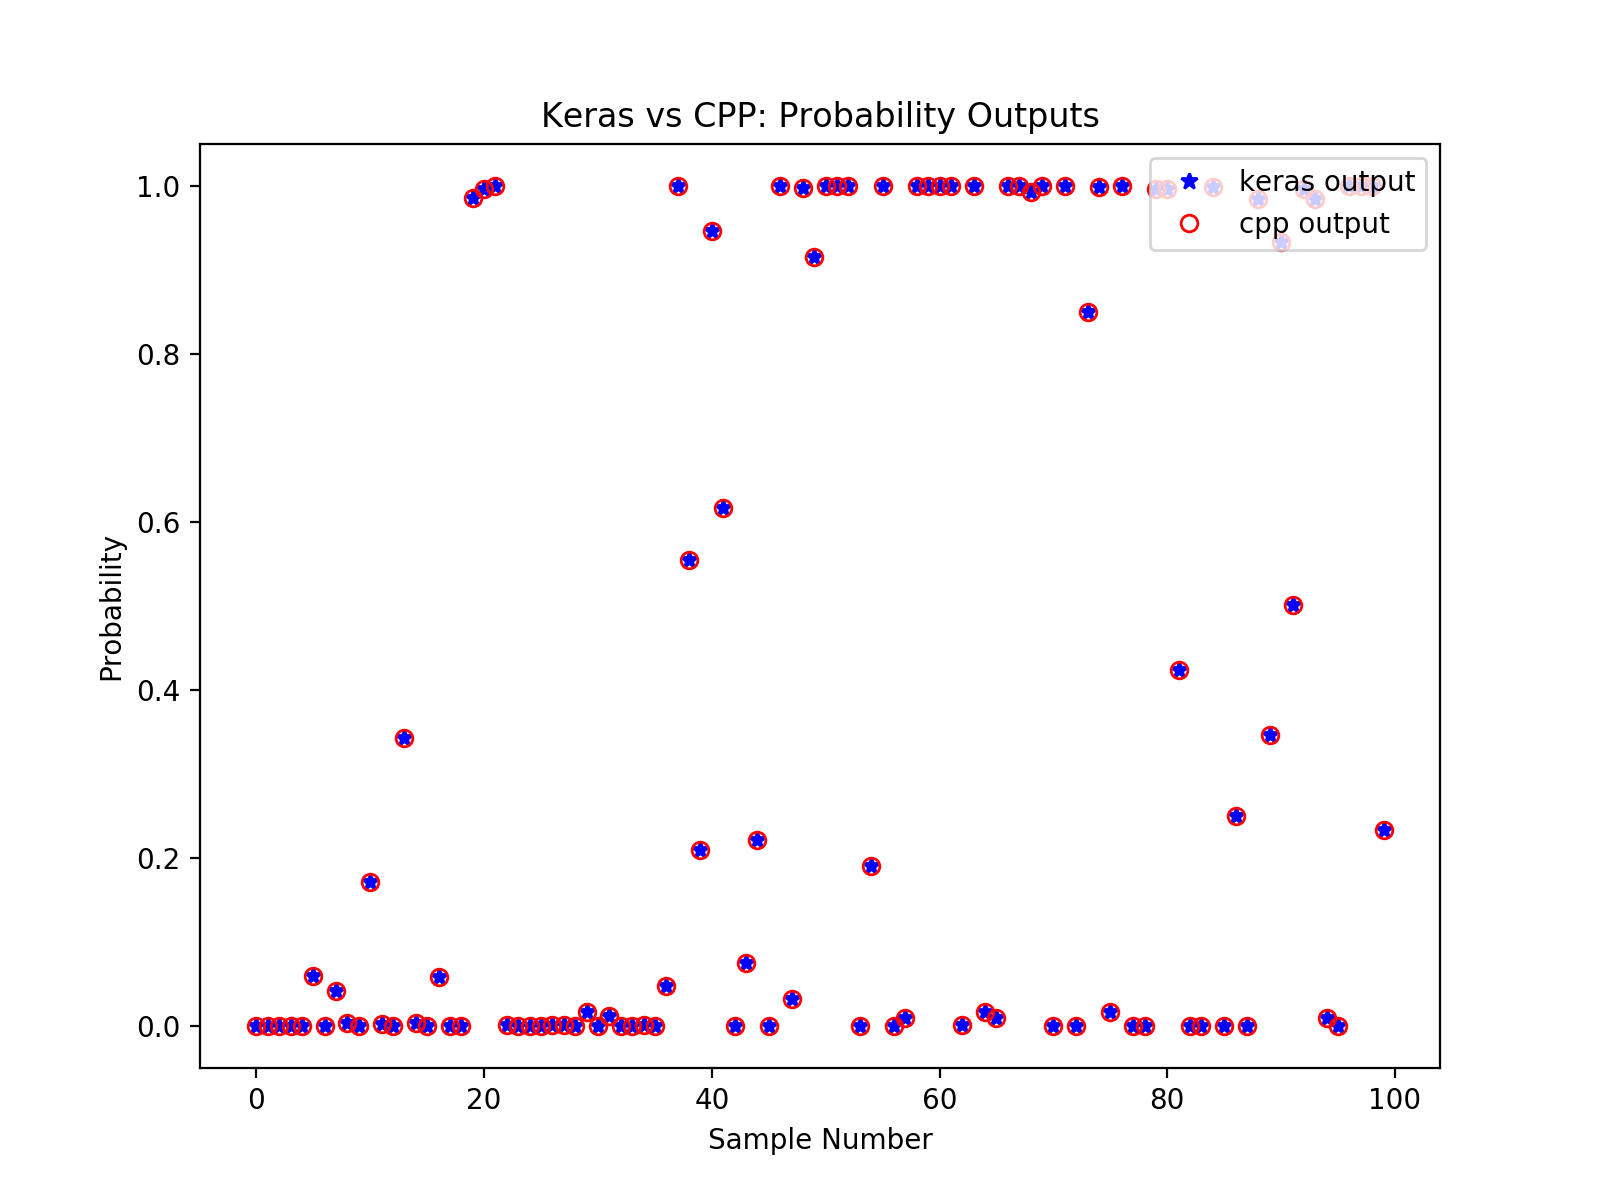

<IPython.core.display.Javascript object>


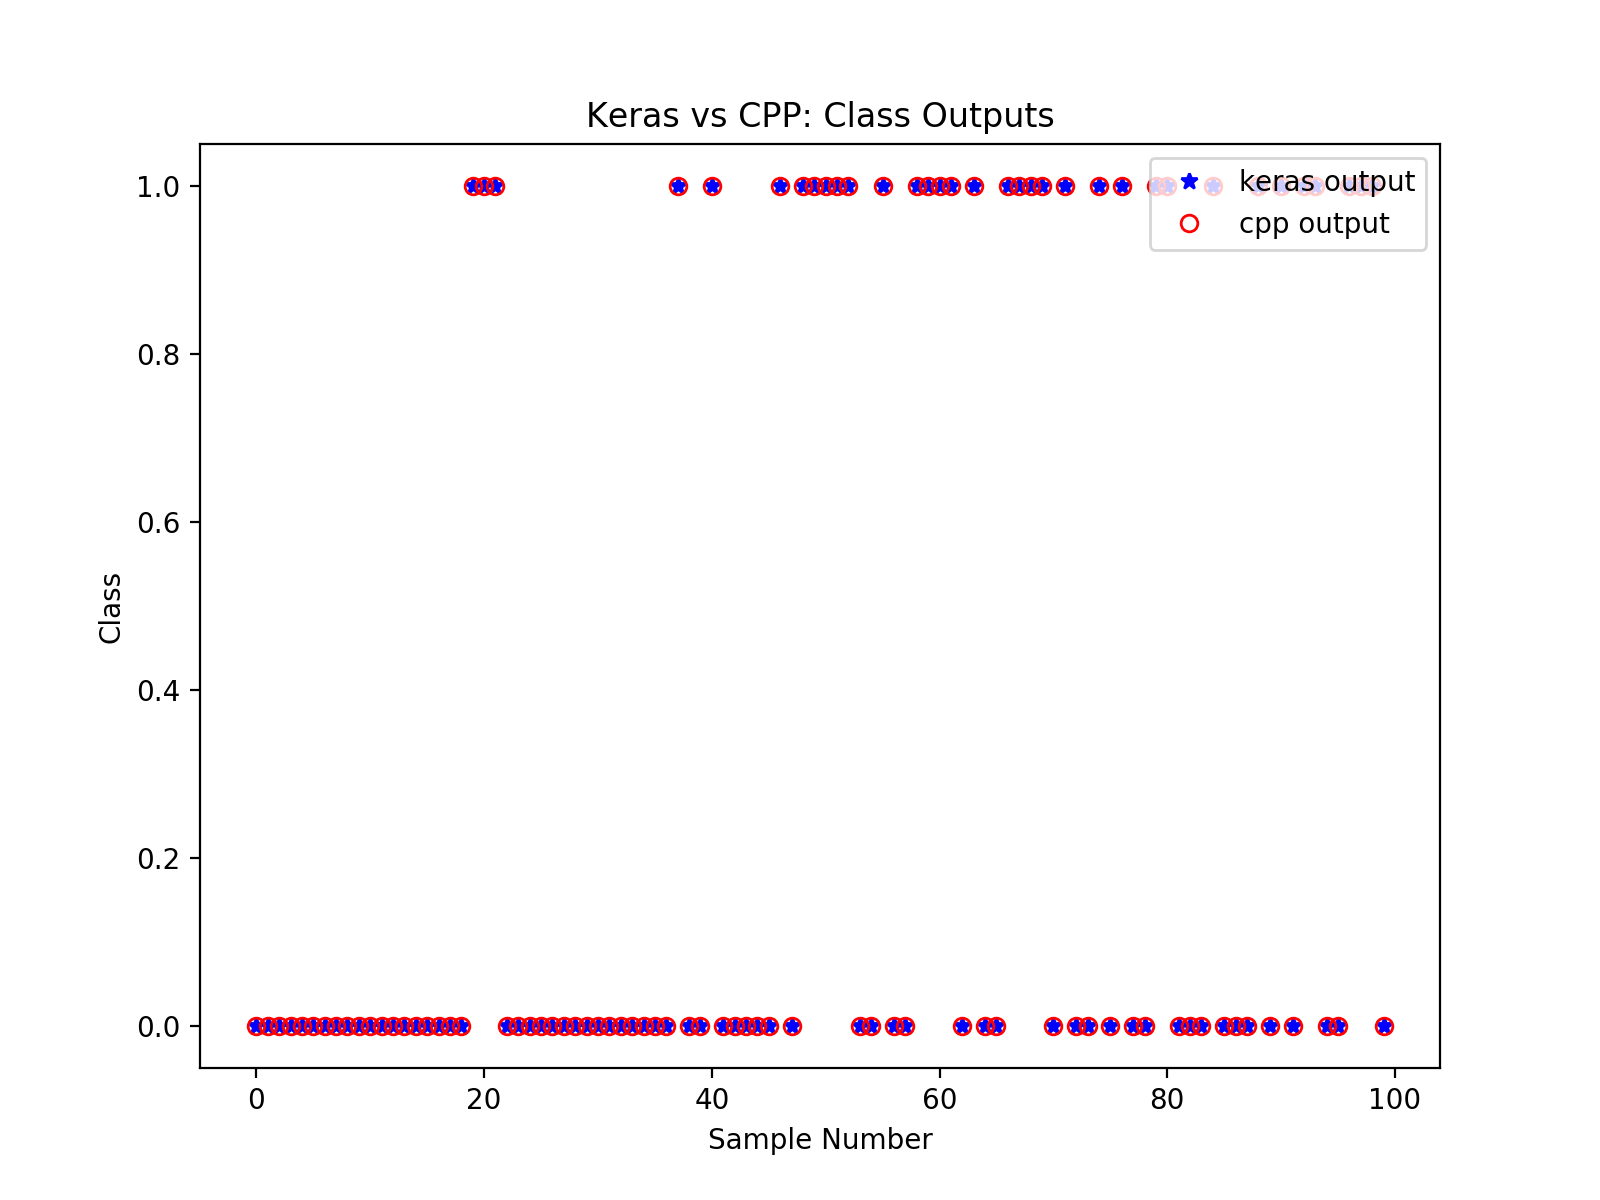

In [4]:
#load test data. just keep first 100 entries to keep things easily interpretable
X = pd.read_pickle('X.pkl').head(100)
y = pd.read_pickle('y.pkl').head(100)

#do the keras version
prob_keras, y_pred_keras = test_keras(X,y)

#do the cpp version
prob_cpp, y_pred_cpp = test_cpp(X,y)

#compare results
fig, ax = plt.subplots(figsize=(8,6))
p = plt.plot(prob_keras, 'b*', label='keras output')
p = plt.plot(prob_cpp, 'ro', label='cpp output', mfc='none')
p = plt.xlabel('Sample Number')
p = plt.ylabel('Probability')
p = plt.legend(loc=1)
p = plt.title('Keras vs CPP: Probability Outputs')
p = plt.show()

fig, ax = plt.subplots(figsize=(8,6))
p = plt.plot(y_pred_keras, 'b*', label='keras output')
p = plt.plot(y_pred_cpp, 'ro', label='cpp output', mfc='none')
p = plt.xlabel('Sample Number')
p = plt.ylabel('Class')
p = plt.title('Keras vs CPP: Class Outputs')
p = plt.legend(loc=1)
p = plt.show()